In [88]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
import seaborn as sns
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight


In [66]:
# Define a Residual Block (Identity Block)
def identity_block(input_tensor, filters):
    f1, f2 = filters

    x = Conv2D(f1, (1, 1), padding='valid')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(f1, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(f2, (1, 1), padding='valid')(x)
    x = BatchNormalization()(x)

    # Add skip connection
    x = Add()([x, input_tensor])
    x = Activation('relu')(x)
    return x

In [67]:
# Define a Convolutional Block
def convolutional_block(input_tensor, filters, strides=(2, 2)):
    f1, f2 = filters

    x = Conv2D(f1, (1, 1), strides=strides, padding='valid')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(f1, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(f2, (1, 1), padding='valid')(x)
    x = BatchNormalization()(x)

    shortcut = Conv2D(f2, (1, 1), strides=strides, padding='valid')(input_tensor)
    shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

In [68]:
# Build the ResNet Model
def build_resnet(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Initial Conv Layer
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same',kernel_regularizer=l2(1e-4))(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # Residual Blocks
    x = convolutional_block(x, filters=(64, 256))
    x = identity_block(x, filters=(64, 256))
    x = identity_block(x, filters=(64, 256))

    x = convolutional_block(x, filters=(128, 512), strides=(2, 2))
    x = identity_block(x, filters=(128, 512))
    x = identity_block(x, filters=(128, 512))
    x = identity_block(x, filters=(128, 512))

    x = convolutional_block(x, filters=(256, 1024), strides=(2, 2))
    x = identity_block(x, filters=(256, 1024))
    x = identity_block(x, filters=(256, 1024))

    x = convolutional_block(x, filters=(512, 2048), strides=(2, 2))
    x = identity_block(x, filters=(512, 2048))
    x = identity_block(x, filters=(512, 2048))

    # Classification Head
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu',kernel_regularizer=l2(1e-4))(x)
    x = Dropout(0.5)(x)  # Dropout for regularization
    outputs = Dense(num_classes, activation='sigmoid',kernel_regularizer=l2(1e-4))(x)

    model = Model(inputs, outputs, name='ResNet')
    return model


In [69]:
# Load and preprocess the data
def load_data(train_dir, test_dir, img_size):
    # Data augmentation with balanced and meaningful transformations for medical images
    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,  # Minimal rotations
    width_shift_range=0.1,
    height_shift_range=0.1,
    #brightness_range=[0.9, 1.1],  # Minimal brightness adjustments
    #zoom_range=0.1,
    horizontal_flip=True,  # Allow horizontal flips (common in medical imaging)
    fill_mode='nearest'
        )

    test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)


    # Train and test generators
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        batch_size=32,
        class_mode='binary'
        )

    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=img_size,
        batch_size=32,
        class_mode='binary',
        shuffle=False  # Important for ROC and AUC calculations
        )
    return train_generator, test_generator

In [70]:
# Paths
train_dir = "chest_xray/train"
test_dir = "chest_xray/test"

In [71]:
# Load data
train_gen, test_gen = load_data(train_dir, test_dir, img_size=(128, 128))

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [72]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_gen.classes),
    y=train_gen.classes
)
class_weights = dict(enumerate(class_weights))

In [ ]:
# Compile and train the model
def train_model(model, train_generator, test_generator, epochs, callbacks, class_weights):
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(
        train_generator, validation_data=test_generator, epochs=epochs, verbose=1, callbacks=callbacks, class_weight=class_weights
    )
    return history

In [74]:
# Plot metrics
def plot_metrics(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss')
    plt.show()

In [75]:
# Evaluate the model
def evaluate_model(model, test_generator):
    test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    # Predict
    y_true = test_generator.classes
    y_pred = (model.predict(test_generator) > 0.5).astype(int).flatten()

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)

    sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=['Normal', 'Pneumonia'],  
    yticklabels=['Normal', 'Pneumonia']
        )
    
    plt.title('Confusion Matrix')
    plt.show()

    # Classification Report
    print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

    # ROC and AUC
    y_prob = model.predict(test_generator).flatten()
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

Epoch 1/15


c:\Users\lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 264s 1s/step - accuracy: 0.6975 - loss: 0.8866 - val_accuracy: 0.6250 - val_loss: 2.0585 - learning_rate: 1.0000e-04
Epoch 2/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 159s 950ms/step - accuracy: 0.8307 - loss: 0.5255 - val_accuracy: 0.6250 - val_loss: 3.2809 - learning_rate: 1.0000e-04
Epoch 3/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 130s 783ms/step - accuracy: 0.8576 - loss: 0.4426 - val_accuracy: 0.6314 - val_loss: 1.8485 - learning_rate: 1.0000e-04
Epoch 4/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 142s 859ms/step - accuracy: 0.8751 - loss: 0.4067 - val_accuracy: 0.7628 - val_loss: 0.7167 - learning_rate: 1.0000e-04
Epoch 5/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - accuracy: 0.8841 - loss: 0.3881 - val_accuracy: 0.5897 - val_loss: 0.9528 - learning_rate: 1.0000e-04
Epoch 6/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 158s 959ms/step - accuracy: 0.9045 - loss: 0.3591 - val_accuracy: 0.6971 - val_loss: 1.0494 - learning_rate: 1.0000e-04
Epoch 7/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accu

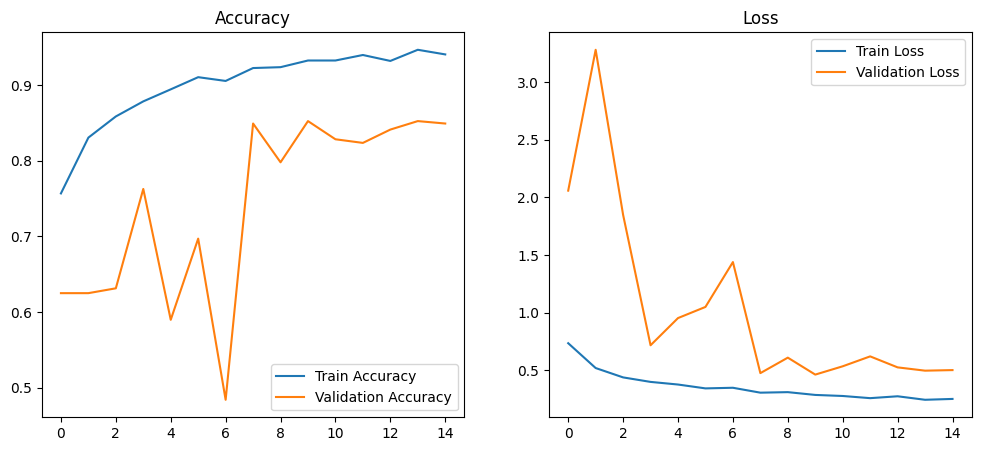

20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 272ms/step - accuracy: 0.8467 - loss: 0.4880
Test Loss: 0.4622
Test Accuracy: 0.8526
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 298ms/step


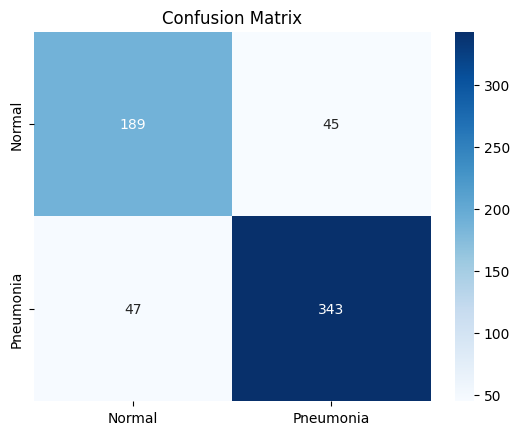

              precision    recall  f1-score   support

      NORMAL       0.80      0.81      0.80       234
   PNEUMONIA       0.88      0.88      0.88       390

    accuracy                           0.85       624
   macro avg       0.84      0.84      0.84       624
weighted avg       0.85      0.85      0.85       624

20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 267ms/step


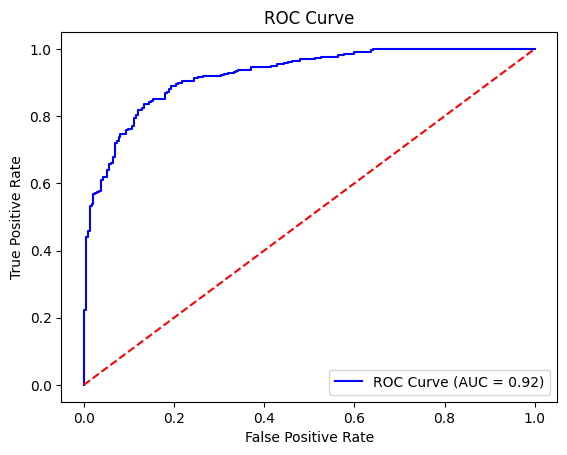

In [76]:
# Main Execution
if __name__ == "__main__":
        
        # Parameters
        input_shape = (128, 128, 3)
        num_classes = 1
        epochs = 15

        # Build ResNet model
        resnet_model = build_resnet(input_shape, num_classes)
        
        # Callbacks
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        model_checkpoint = tf.keras.callbacks.ModelCheckpoint('best_resnet_model.keras', monitor='val_loss', save_best_only=True)
        lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
        callbacks = [early_stopping, model_checkpoint, lr_scheduler]

        # Train model
        history = train_model(
            resnet_model,
            train_gen,
            test_gen,
            epochs=epochs,
            callbacks=callbacks,
            class_weights=class_weights
            )
        
        
        # Plot metrics
        plot_metrics(history)

        # Evaluate the model
        evaluate_model(resnet_model, test_gen)

In [77]:
# Print model summary
resnet_model.summary() # model architecture

Model: "ResNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_176 (Conv2D) │ (None, 64, 64,    │      9,472 │ input_layer_4[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_176[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_160      │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 32, 32,    │          0 │ activation_160[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_177 (Conv2D) │ (None, 16, 16,    │      4,160 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        256 │ conv2d_177[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_161      │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_178 (Conv2D) │ (None, 16, 16,    │     36,928 │ activation_161[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        256 │ conv2d_178[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_162      │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_179 (Conv2D) │ (None, 16, 16,    │     16,640 │ activation_162[0… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_180 (Conv2D) │ (None, 16, 16,    │     16,640 │ max_pooling2d_4[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │      1,024 │ conv2d_179[0][0]  │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │      1,024 │ conv2d_180[0][0]  │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_52 (Add)        │ (None, 16, 16,    │          0 │ batch_normalizat… │
│                     │ 256)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_163      │ (None, 16, 16,    │          0 │ add_52[0][0]    

 Total params: 66,876,805 (255.11 MB)

 Trainable params: 22,277,633 (84.98 MB)

 Non-trainable params: 43,904 (171.50 KB)

 Optimizer params: 44,555,268 (169.96 MB)

# Load the saved model 

In [78]:
# Path to test directory
test_dir = "chest_xray/test"


In [79]:
# Load the test data
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    shuffle=False  # Important for ROC and AUC calculations
)

Found 624 images belonging to 2 classes.


In [80]:
# Build ResNet model
resnet_model = build_resnet(input_shape, num_classes)

In [81]:
# Load the saved weights
resnet_model.load_weights('best_resnet_model.keras')

In [82]:
# Compile the model (required for evaluation)
resnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [83]:
# Evaluate the model on test data
test_loss, test_accuracy = resnet_model.evaluate(test_generator, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

c:\Users\lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 262ms/step - accuracy: 0.8467 - loss: 0.4880
Test Loss: 0.4622
Test Accuracy: 0.8526


In [84]:
# Predict probabilities and labels
y_true = test_generator.classes
y_prob = resnet_model.predict(test_generator).flatten()
y_pred = (y_prob > 0.5).astype(int)

20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 298ms/step


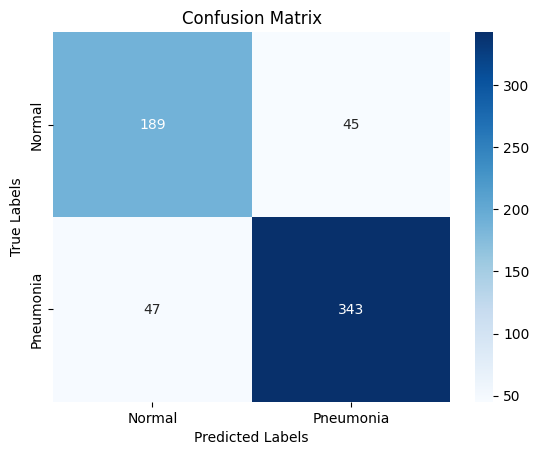

In [85]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Pneumonia'],
            yticklabels=['Normal', 'Pneumonia'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [86]:
# Classification Report
print(classification_report(y_true, y_pred, target_names=['Normal', 'Pneumonia']))


              precision    recall  f1-score   support

      Normal       0.80      0.81      0.80       234
   Pneumonia       0.88      0.88      0.88       390

    accuracy                           0.85       624
   macro avg       0.84      0.84      0.84       624
weighted avg       0.85      0.85      0.85       624



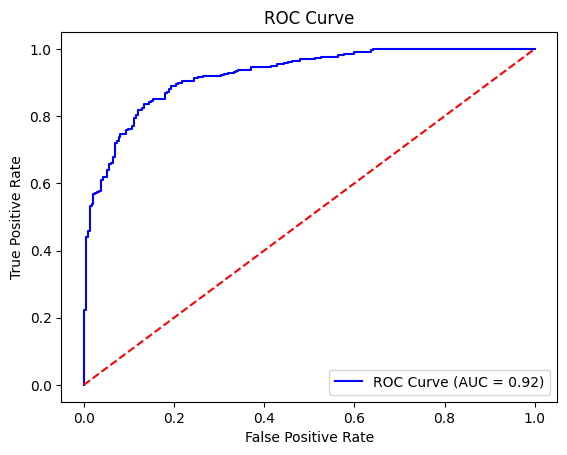

In [87]:
# ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [89]:
# AUC Score
auc = roc_auc_score(y_true, resnet_model.predict(test_generator).ravel())
print(f'AUC Score: {auc:.4f}')

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 240ms/step
AUC Score: 0.9233
